# Exploratory Data Analysis (EDA)

## Projet : Prévision et monitoring des comportements clients



In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use("default")

In [3]:
df = pd.read_excel("../data/online_retail_II.xlsx")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


1️- Invoice et StockCode

certaines factures sont répétées → multiple produits par facture.


In [5]:
print("Nombre de factures uniques:", df['Invoice'].nunique())
print("Nombre de produits uniques:", df['StockCode'].nunique())


Nombre de factures uniques: 28816
Nombre de produits uniques: 4632


2️- Description

la description est utile pour analyse qualitative mais pas directement pour la prévision temporelle.

In [6]:
print("Valeurs manquantes Description:", df['Description'].isna().sum())
print("Produits uniques Description:", df['Description'].nunique())


Valeurs manquantes Description: 2928
Produits uniques Description: 4681


3️-Quantity

ces valeurs seront nettoyées plus tard.

Nombre de transactions avec quantité <= 0: 12326


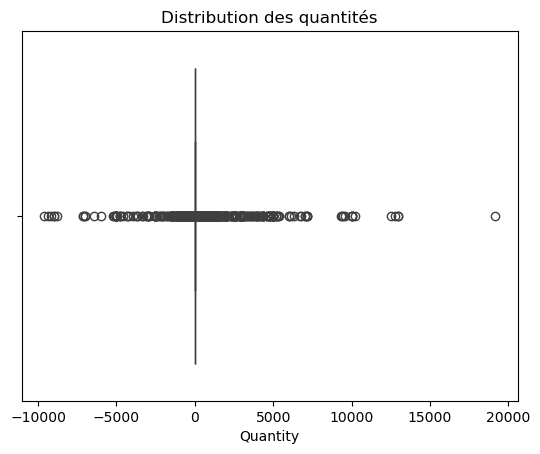

In [7]:
negative_qty = df[df['Quantity'] <= 0].shape[0]
print("Nombre de transactions avec quantité <= 0:", negative_qty)

sns.boxplot(x=df['Quantity'])
plt.title("Distribution des quantités")
plt.show()


4️-InvoiceDate

Vérifier période couverte


In [8]:
print("Première date:", df['InvoiceDate'].min())
print("Dernière date:", df['InvoiceDate'].max())


Première date: 2009-12-01 07:45:00
Dernière date: 2010-12-09 20:01:00


5️- Price

Vérifier valeurs négatives ou zéro

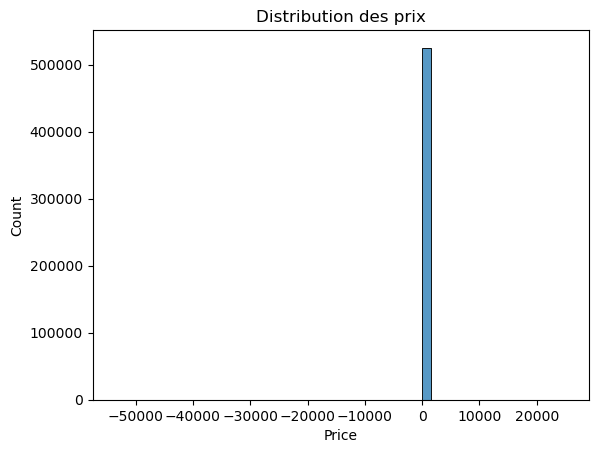

In [10]:
sns.histplot(df['Price'],bins=50)
plt.title("Distribution des prix")
plt.show()

6️-Customer ID



Vérifier nombre unique de clients

Valeurs manquantes → ces transactions peuvent être exclues pour certaines analyses

In [11]:
print("Valeurs manquantes Customer ID:", df['Customer ID'].isna().sum())
print("Nombre de clients uniques:", df['Customer ID'].nunique())


Valeurs manquantes Customer ID: 107927
Nombre de clients uniques: 4383


7️-Country



Distribution par pays 

Utile pour éventuellement filtrer sur un seul pays

In [12]:
df['Country'].value_counts().head(10)

Country
United Kingdom     485852
EIRE                 9670
Germany              8129
France               5772
Netherlands          2769
Spain                1278
Switzerland          1187
Portugal             1101
Belgium              1054
Channel Islands       906
Name: count, dtype: int64

8️-Vérification des doublons globaux

In [14]:
print('Nombre de doublons:',df.duplicated().sum())

Nombre de doublons: 6865


## Observations par colonne (EDA)

- **Invoice / StockCode** : Chaque facture peut contenir plusieurs produits. Pas de problème majeur, mais important pour comprendre les regroupements.
- **Description** : 2 928 valeurs manquantes (~0.5%). 4 681 produits uniques. Pas critique pour la prévision temporelle.
- **Quantity** : 12 326 transactions avec quantité ≤ 0, correspondant à des retours ou erreurs. Nécessité de nettoyer avant modélisation.
- **InvoiceDate** : Période couverte : 01/12/2009 – 09/12/2010. Données exploitables pour l’analyse temporelle.
- **Price** : Certaines valeurs ≤ 0 (anomalies). Distribution concentrée sur petites valeurs positives, quelques valeurs extrêmes à traiter.
- **Customer ID** : 107 927 valeurs manquantes (~20%), 4 383 clients uniques. Les transactions sans ID client peuvent être ignorées pour certaines analyses clients.
- **Country** : La majorité des transactions sont au Royaume-Uni (485 852), autres pays minoritaires. Possibilité de filtrer sur UK si nécessaire.
- **Doublons** : 6 865 doublons détectés. À supprimer dans la phase de nettoyage.



Préparer la date

In [15]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.dropna(subset=["InvoiceDate"])


Volume journalier des transactions

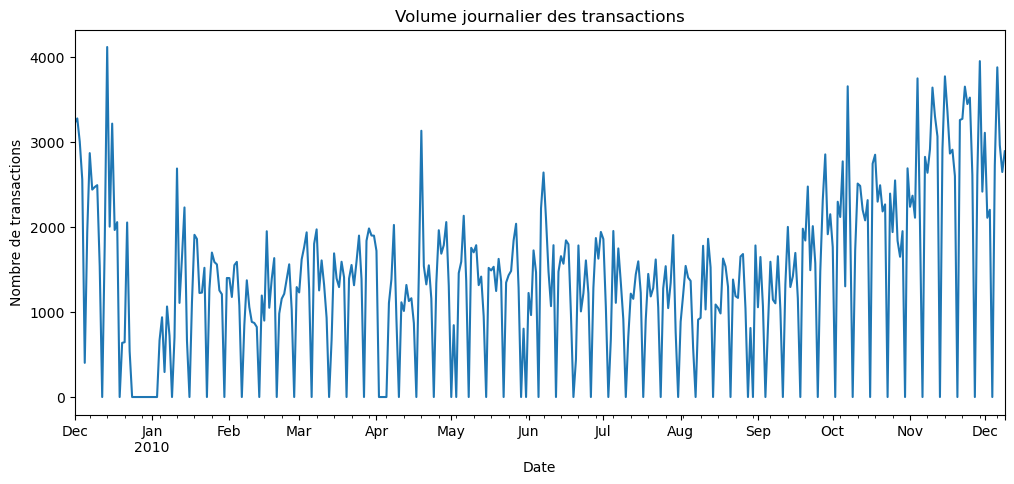

In [16]:
daily_tx = df.set_index("InvoiceDate").resample("D").size()

plt.figure(figsize=(12,5))
daily_tx.plot()
plt.title("Volume journalier des transactions")
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.show()


### Observation
Le volume journalier montre des variations importantes avec des pics et des creux. La tendance n'est pas constante → non stationnaire.


Chiffre d’affaires dans le temps

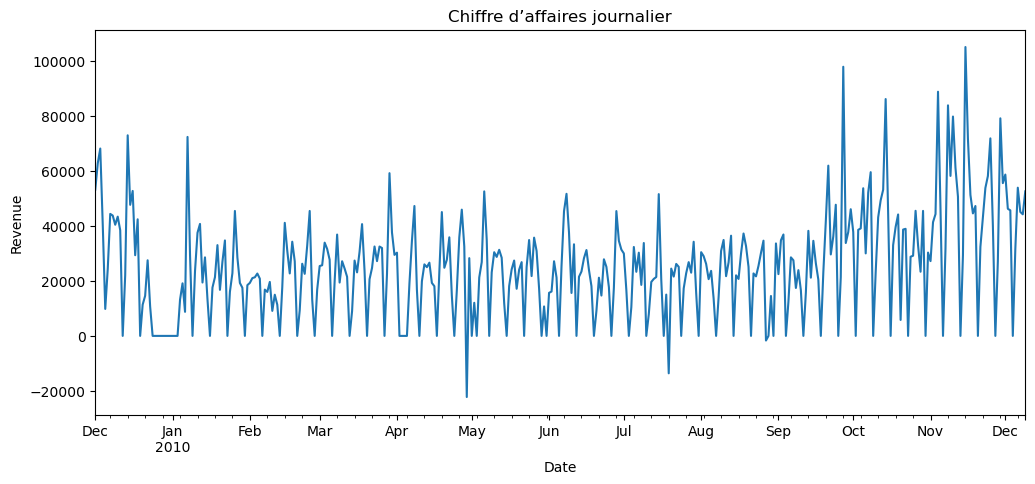

In [17]:
df["Revenue"] = df["Quantity"] * df["Price"] 
daily_revenue = df.set_index("InvoiceDate").resample("D")["Revenue"].sum()

plt.figure(figsize=(12,5))
daily_revenue.plot()
plt.title("Chiffre d’affaires journalier")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


## Corrélation Volume vs Chiffre d'Affaires

La corrélation entre volume et chiffre d'affaires est globalement positive mais non linéaire. On observe une **tendance haussière marquée du chiffre d'affaires en Q4** (octobre-décembre) disproportionnée par rapport au volume, suggérant une augmentation du montant moyen par transaction. Les **valeurs négatives** détectées (mai, août) indiquent probablement des remboursements ou ajustements comptables. La volatilité accrue en fin d'année pour les deux métriques reflète une forte saisonnalité commerciale. Ces variations dans le ratio revenu/volume méritent une analyse approfondie de la structure des transactions.

Saisonnalité


Par mois :


C:\Users\21263\AppData\Local\Temp\ipykernel_8248\4207176496.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_tx = df.set_index("InvoiceDate").resample("M").size()


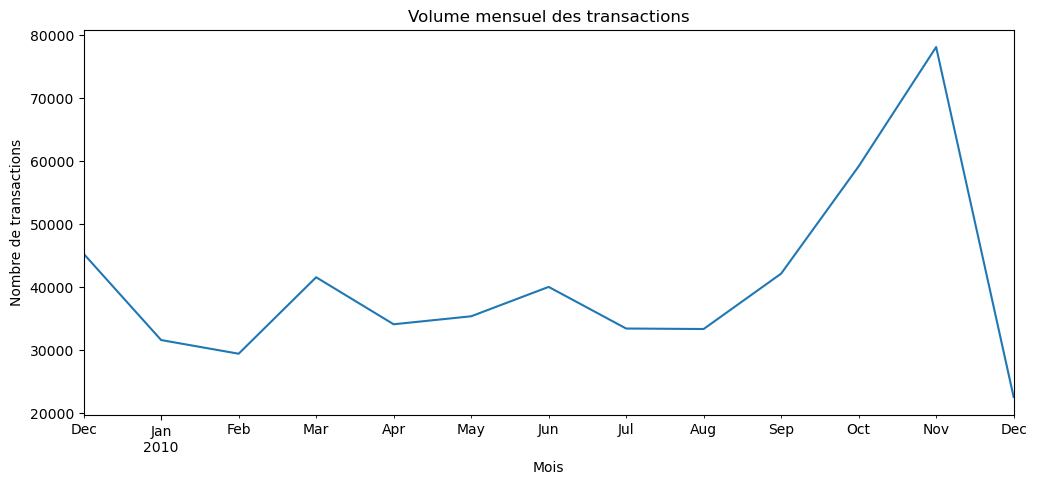

In [18]:
monthly_tx = df.set_index("InvoiceDate").resample("M").size()
monthly_tx.plot(figsize=(12,5))
plt.title("Volume mensuel des transactions")
plt.xlabel("Mois")
plt.ylabel("Nombre de transactions")
plt.show()


Par jour de la semaine

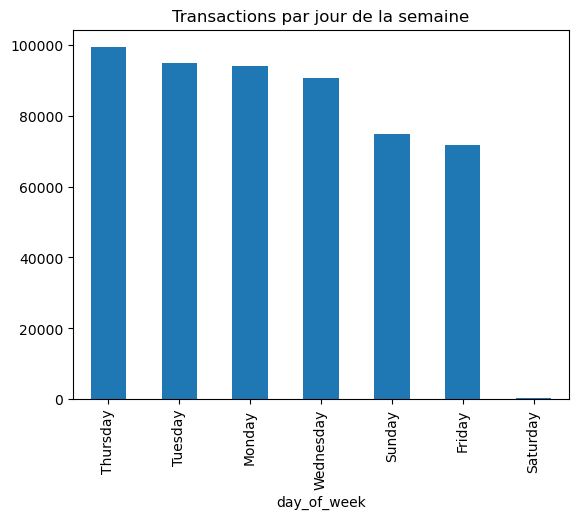

In [19]:
df['day_of_week'] = df['InvoiceDate'].dt.day_name()
df['day_of_week'].value_counts().plot(kind='bar')
plt.title("Transactions par jour de la semaine")
plt.show()


## Conclusion de l’EDA

- Les données présentent une tendance et une saisonnalité.
- L’activité est non stationnaire.
- Présence d’anomalies (quantités négatives, prix extrêmes).
- Une modélisation en séries temporelles est pertinente.
- Les prochaines étapes : nettoyage, feature engineering et préparation du dataset pour modélisation.
